In [1]:
import os
import pandas as pd
import numpy as np
from  datetime import datetime
from  datetime import timedelta
import matplotlib.pylab as plt
import seaborn as sns
import gc
from itertools import cycle
import warnings
from matplotlib.patches import Polygon
from dateutil.relativedelta import relativedelta
import lightgbm as lgb
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
color_pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_cycle = cycle(color_pal)

# EDA

### 資料欄位型態設定

In [5]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "category", 'snap_TX': 'category', 'snap_WI': 'category'}
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float16"}
DATA_FOLDER = "./Data"

### 時間變數設定

In [6]:
h = 28 
max_lags = 70
tr_last = 1913
fday = datetime(2016,4, 25)
FIRST_DAY = 1

### 資料讀取

In [4]:
price = pd.read_csv(f'{DATA_FOLDER}/sell_prices.csv', dtype=PRICE_DTYPES)
calendar = pd.read_csv(f'{DATA_FOLDER}/calendar.csv', dtype=CAL_DTYPES)
sales_v = pd.read_csv(f'{DATA_FOLDER}/sales_train_validation.csv')
# sales_e = pd.read_csv(f'{DATA_FOLDER}/sales_train_evaluation.csv')
# sub = pd.read_csv(f'{DATA_FOLDER}/sample_submission.csv')

In [5]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
sales_v.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [8]:
# sales_e.head()

In [9]:
# sub.head()

In [10]:
sales_v.id.nunique()

30490

In [11]:
# 類別欄位
other_id = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
# 時間欄位
d_cols = [c for c in sales_v.columns if 'd_' in c]

### 商品銷售視覺化

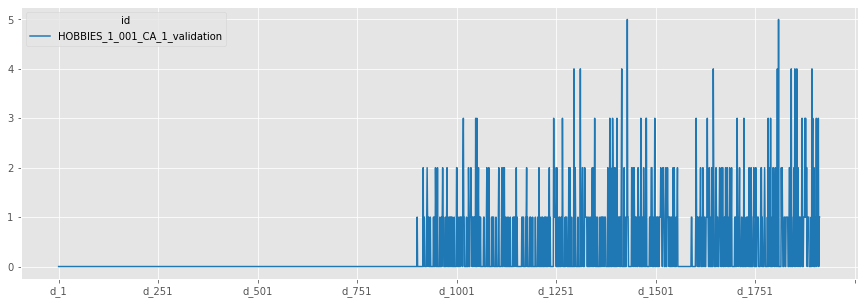

In [12]:
sales_v.loc[sales_v['id'] == 'HOBBIES_1_001_CA_1_validation'].set_index('id')[d_cols].T.plot(figsize=(15, 5), color=next(color_cycle))
plt.show()

In [13]:
calendar[['d','date','event_name_1','event_name_2',
          'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


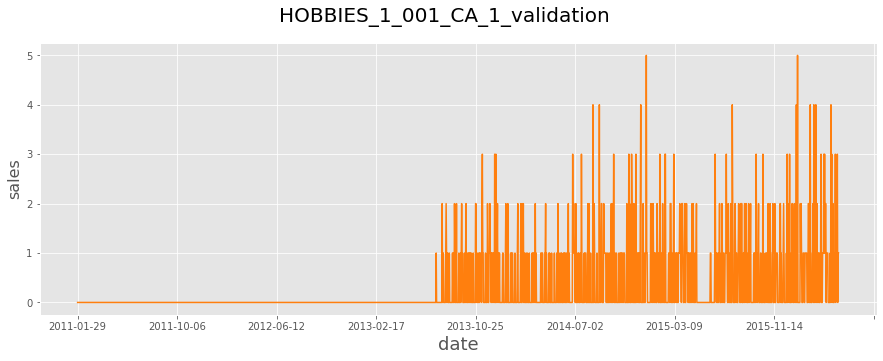

In [14]:
example = sales_v.loc[sales_v['id'] == 'HOBBIES_1_001_CA_1_validation'][d_cols].T
example = example.rename(columns={0:'HOBBIES_1_001_CA_1'})
example = example.reset_index().rename(columns={'index': 'd'})
example = example.merge(calendar, how='left', validate='1:1')
example.set_index('date')['HOBBIES_1_001_CA_1'].plot(figsize=(15, 5), color=next(color_cycle))
plt.suptitle('HOBBIES_1_001_CA_1_validation', fontsize=20)
plt.xlabel('date', fontsize=18)
plt.ylabel('sales', fontsize=16)
plt.show()

In [15]:
# 清除變數釋放記憶體
del example
gc.collect()

6994

### 找出每種類型商品銷售最多的商品

In [16]:
ex = sales_v.drop(other_id, axis=1).T.reset_index().copy()
ex.columns = ex.iloc[0]
ex = ex.drop(0).reset_index(drop=True).rename(columns={'id': 'date'})
ex = ex.apply(lambda x: pd.to_numeric(x, errors='ignore'))
ex.head()

,date,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,...,FOODS_3_803_WI_3_validation,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,d_1,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2,d_3,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
4,d_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [17]:
sells = ex.sum().drop('date').sort_values(ascending=False).to_frame().rename(columns={0: 'values'}).reset_index().rename(columns={0: 'items'}).copy()
sells['category'] = sells['items'].apply(lambda x: x.split("_")[0])
sells.head()

,items,values,category
0,FOODS_3_090_CA_3_validation,250502,FOODS
1,FOODS_3_586_TX_2_validation,192835,FOODS
2,FOODS_3_586_TX_3_validation,150122,FOODS
3,FOODS_3_586_CA_3_validation,134386,FOODS
4,FOODS_3_090_CA_1_validation,127203,FOODS


In [18]:
sells['category'].unique()

array(['FOODS', 'HOUSEHOLD', 'HOBBIES'], dtype=object)

In [19]:
sells.loc[sells['category'] == 'FOODS'].head()

,items,values,category
0,FOODS_3_090_CA_3_validation,250502,FOODS
1,FOODS_3_586_TX_2_validation,192835,FOODS
2,FOODS_3_586_TX_3_validation,150122,FOODS
3,FOODS_3_586_CA_3_validation,134386,FOODS
4,FOODS_3_090_CA_1_validation,127203,FOODS


In [20]:
sells.loc[sells['category'] == 'HOUSEHOLD'].head()

,items,values,category
65,HOUSEHOLD_1_118_CA_3_validation,43351,HOUSEHOLD
97,HOUSEHOLD_1_459_CA_3_validation,36970,HOUSEHOLD
98,HOUSEHOLD_1_334_CA_3_validation,36811,HOUSEHOLD
112,HOUSEHOLD_1_303_CA_3_validation,34897,HOUSEHOLD
150,HOUSEHOLD_1_521_CA_3_validation,30266,HOUSEHOLD


In [21]:
sells.loc[sells['category'] == 'HOBBIES'].head()

,items,values,category
152,HOBBIES_1_234_CA_3_validation,29742,HOBBIES
265,HOBBIES_1_348_CA_1_validation,22744,HOBBIES
271,HOBBIES_1_371_CA_1_validation,22595,HOBBIES
307,HOBBIES_1_254_CA_3_validation,20996,HOBBIES
340,HOBBIES_1_371_CA_3_validation,19812,HOBBIES


In [22]:
# 清除變數釋放記憶體
del ex, sells
gc.collect()

22

### 銷售最多的商品的週月年規律

In [23]:
example1 = sales_v.loc[sales_v['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T.copy()
example1 = example1.rename(columns={8412:'FOODS_3_090_CA_3'})
example1 = example1.reset_index().rename(columns={'index': 'd'})
example1 = example1.merge(calendar, how='left', validate='1:1')

In [24]:
example2 = sales_v.loc[sales_v['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T.copy()
example2 = example2.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'})
example2 = example2.reset_index().rename(columns={'index': 'd'})
example2 = example2.merge(calendar, how='left', validate='1:1')

In [25]:
example3 = sales_v.loc[sales_v['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T.copy()
example3 = example3.rename(columns={6324:'HOBBIES_1_234_CA_3'})
example3 = example3.reset_index().rename(columns={'index': 'd'})
example3 = example3.merge(calendar, how='left', validate='1:1')

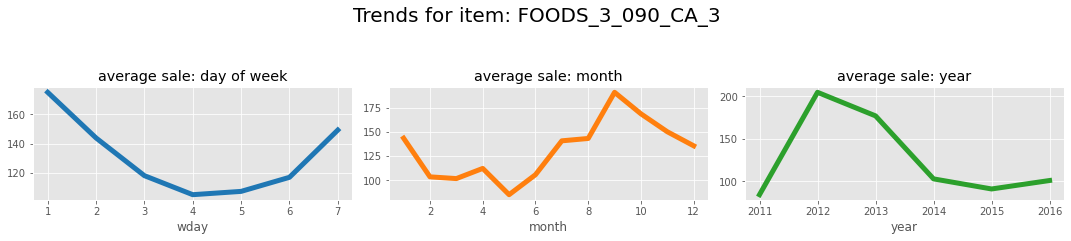

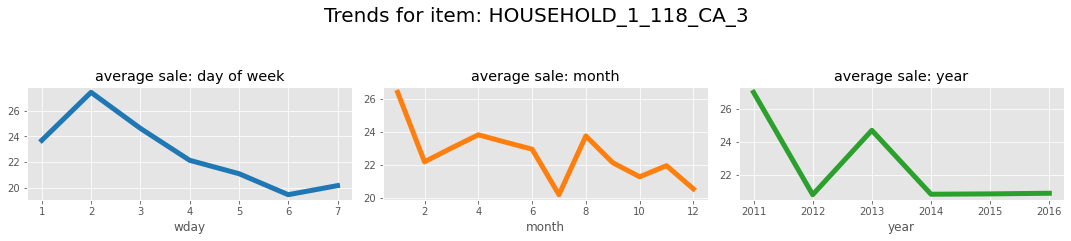

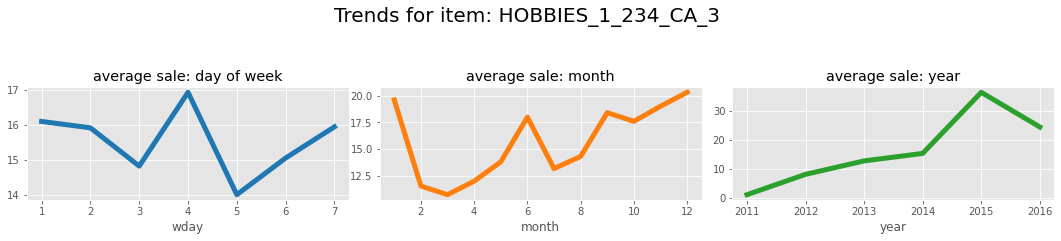

In [26]:
examples = ['FOODS_3_090_CA_3','HOUSEHOLD_1_118_CA_3', 'HOBBIES_1_234_CA_3']
example_df = [example1, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[1],
              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

In [27]:
# 清除變數釋放記憶體
del example1, example2, example3
gc.collect()

18102

### 隨機抽樣20個商品_商家來看銷售規律

In [28]:
examples_20 = sales_v.sample(20, random_state=42).set_index('id')[d_cols].T.copy() \
                        .merge(calendar.set_index('d')['date'],
                               left_index=True,
                               right_index=True,
                               validate='1:1').set_index('date')

In [29]:
examples_20.head()

,FOODS_3_180_CA_1_validation,HOUSEHOLD_2_383_CA_3_validation,FOODS_3_409_CA_3_validation,FOODS_1_097_CA_2_validation,HOBBIES_1_272_TX_2_validation,HOUSEHOLD_1_064_CA_4_validation,FOODS_2_368_TX_2_validation,HOUSEHOLD_1_395_TX_3_validation,HOUSEHOLD_1_537_CA_1_validation,HOUSEHOLD_2_410_TX_2_validation,HOBBIES_1_343_WI_3_validation,FOODS_3_096_CA_1_validation,FOODS_3_161_CA_3_validation,HOUSEHOLD_2_004_CA_2_validation,FOODS_3_118_TX_1_validation,HOBBIES_2_034_CA_3_validation,FOODS_3_456_CA_4_validation,FOODS_3_307_CA_3_validation,FOODS_3_192_WI_2_validation,HOUSEHOLD_1_298_WI_1_validation
date,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2,0,0,0,0,14,5,3,1,0,0,0,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,14,3,1,1,0,2,0,0,6,0,0,0,0,0
2011-01-31,0,2,0,0,0,0,9,0,1,1,1,1,1,0,11,1,0,0,0,0
2011-02-01,0,0,0,0,0,0,14,1,0,0,0,1,0,0,9,0,0,0,0,0
2011-02-02,0,2,0,0,0,0,7,0,1,1,0,4,2,0,9,0,0,0,0,0


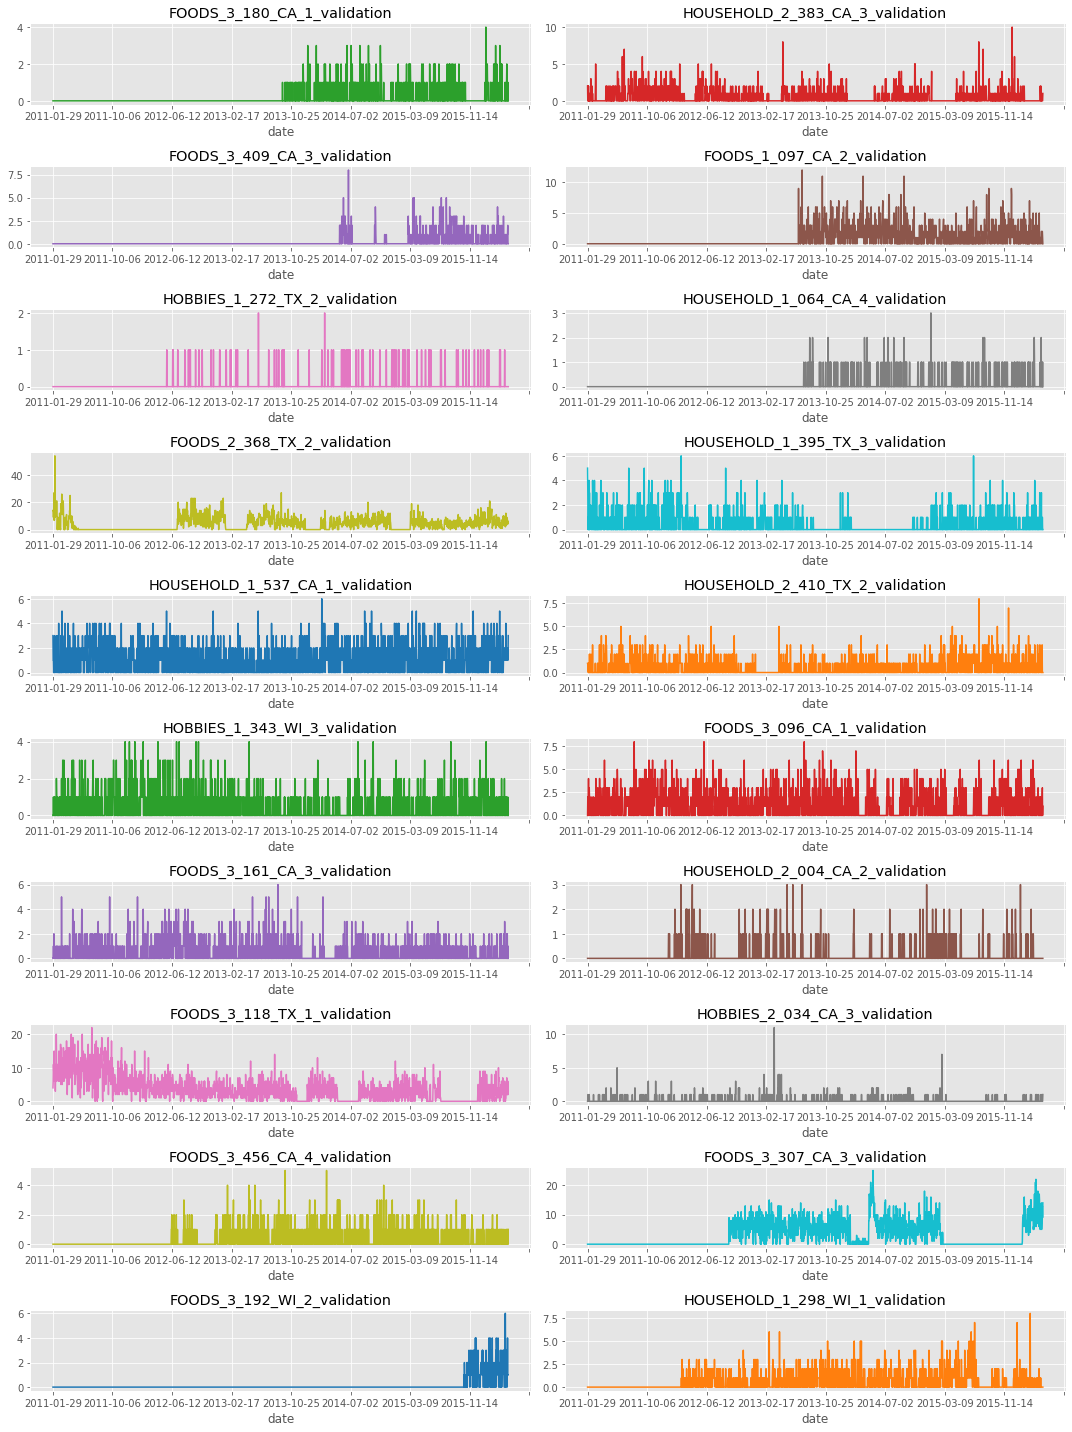

In [30]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in examples_20.columns:
    examples_20[item].plot(title=item,
                           color=next(color_cycle),
                           ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

In [31]:
# 清除變數釋放記憶體
del examples_20
gc.collect()

349

### 不同種類商品數統計

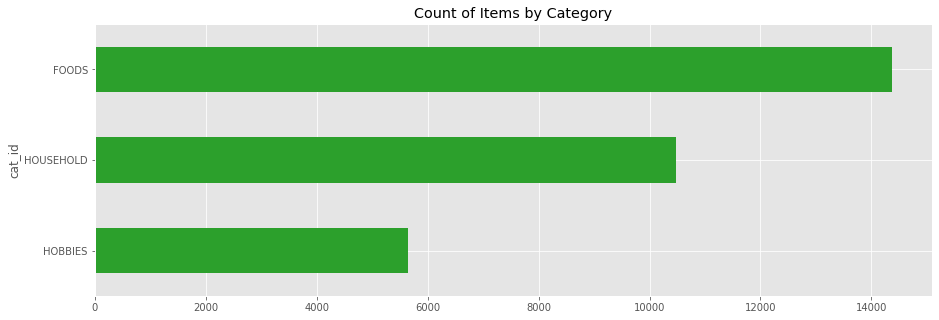

In [32]:
sales_v.groupby('cat_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category', color=next(color_cycle))
plt.show()

### 不同種類商品的銷售變化

In [33]:
past_sales = sales_v.set_index('id')[d_cols].T.copy() \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
           validate='1:1').set_index('date')

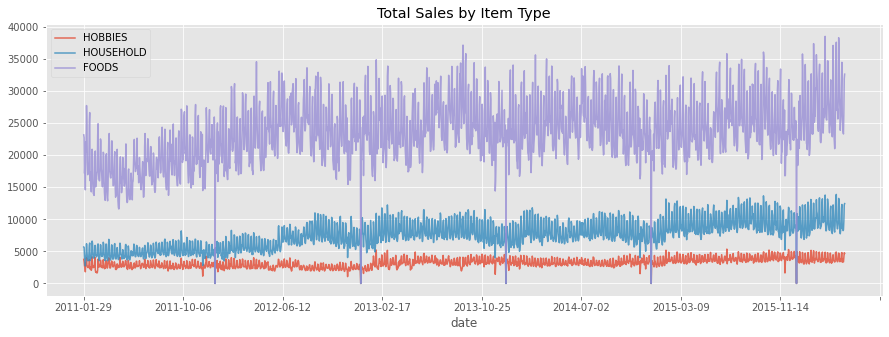

In [34]:
for i in sales_v['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(sales_v['cat_id'].unique())
plt.show()

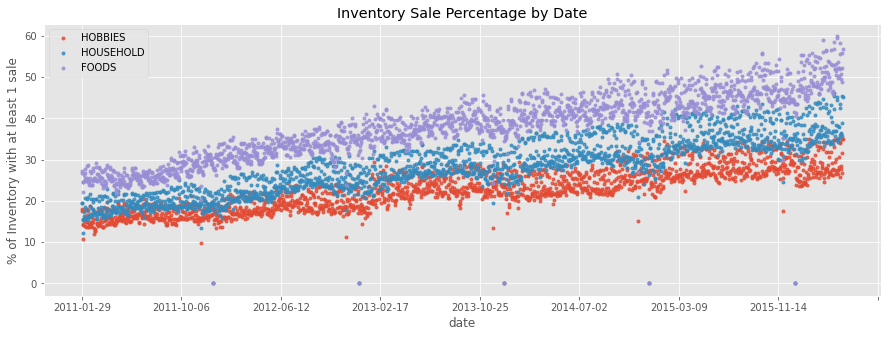

In [35]:
past_sales_clipped = past_sales.clip(0, 1).copy()
for i in sales_v['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col].mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(sales_v['cat_id'].unique())
plt.show()

### 不同商家的銷售變化

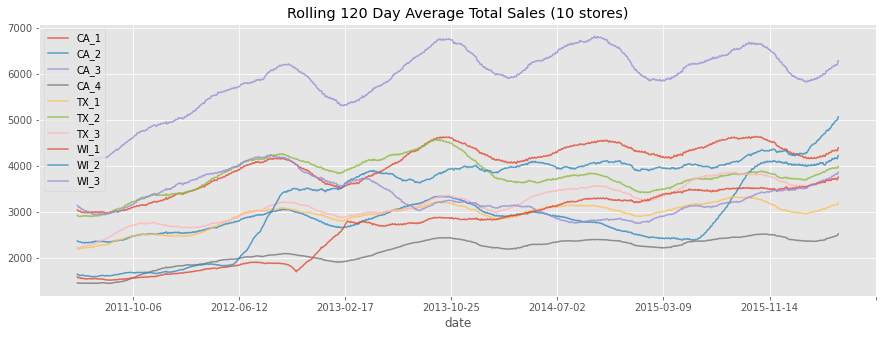

In [36]:
store_list = price['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1) \
        .rolling(120).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 120 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

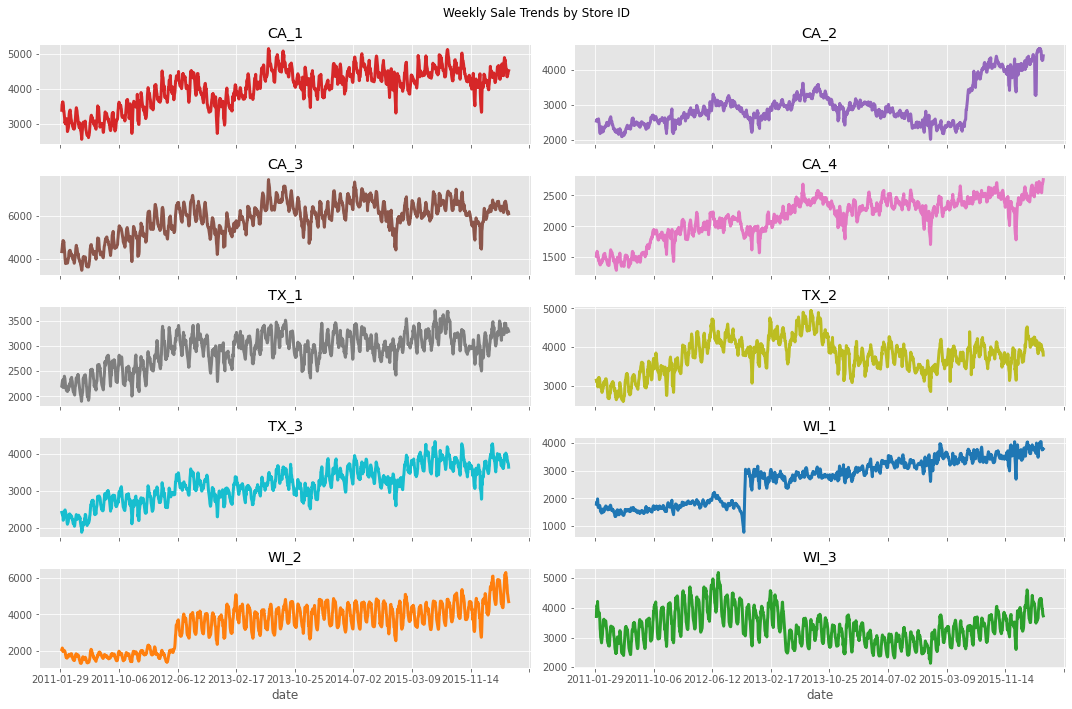

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

In [38]:
# 清除變數釋放記憶體
del past_sales_clipped
gc.collect()

17272

### 熱力圖(月份和商品銷售關聯)

In [39]:
# heat map
def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

In [40]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The highest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The highest sale date was: 2016-03-06 with 57218 sales


In [41]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)

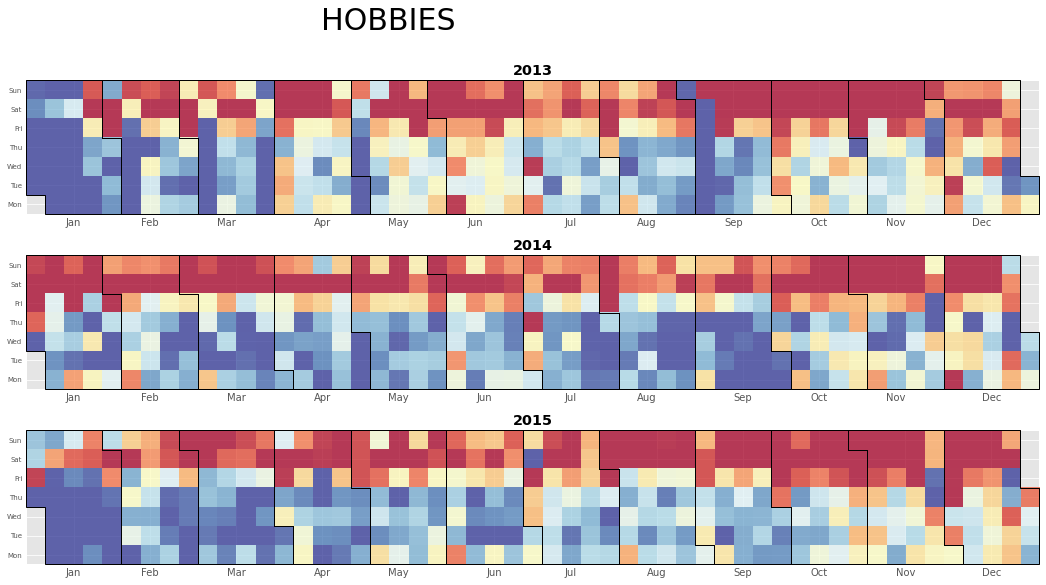

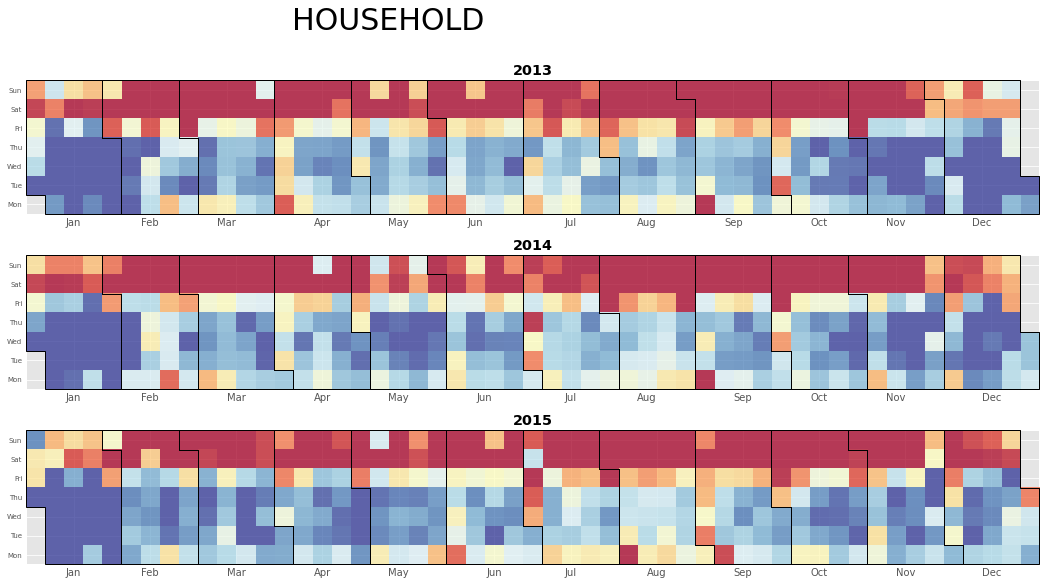

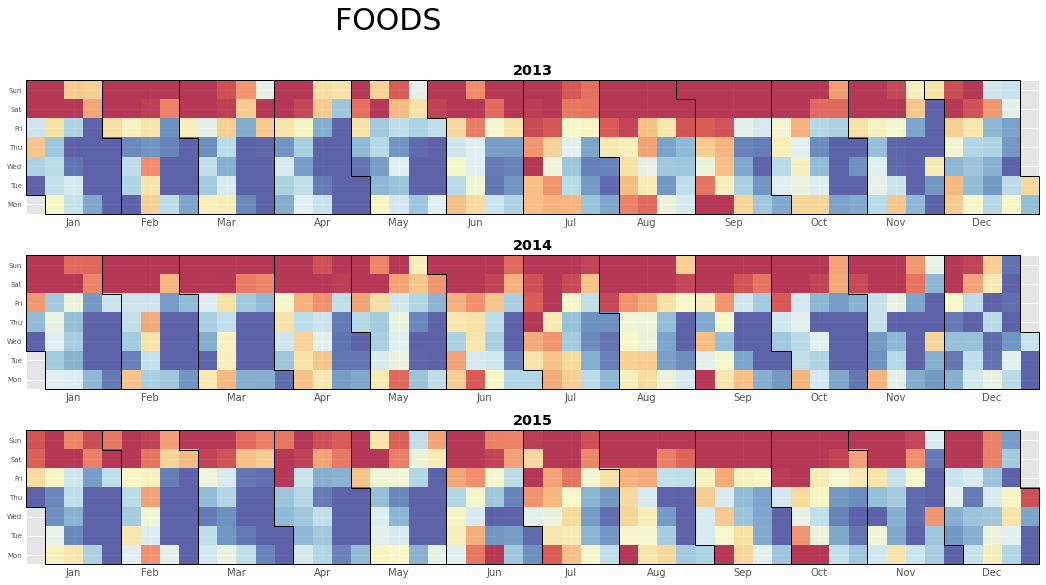

In [42]:
for i in sales_v['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(std_sc.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(std_sc.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(std_sc.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

### 商品_商家價格變化

In [43]:
price_his = price.merge(calendar).query('item_id == "FOODS_3_090"').sort_values(['date']).groupby('store_id')

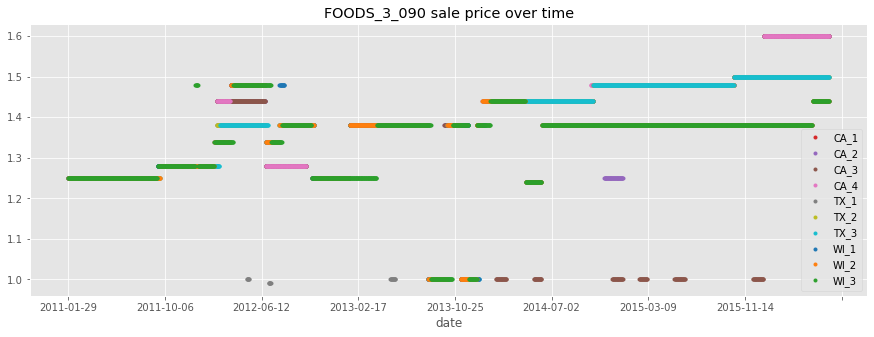

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in price_his:
    d.plot(x='date',
           y='sell_price',
           style='.',
           color=next(color_cycle),
           figsize=(15, 5),
           title='FOODS_3_090 sale price over time',
           ax=ax,
           legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

### 商品價格分佈

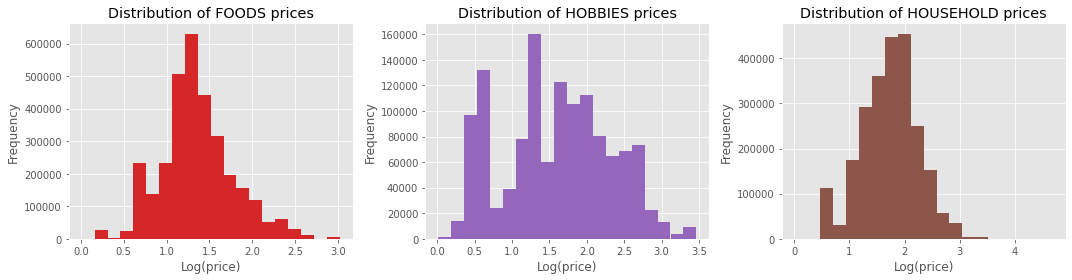

In [45]:
price['Category'] = price['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in price.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
              bins=20,
              title=f'Distribution of {cat} prices',
              ax=axs[i],
              color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

In [46]:
# 清除變數釋放記憶體
del price_his, past_sales, sales_v, price, calendar
gc.collect()

42

### 資料讀取和整合

In [2]:
def create_df(is_train=True, nrows=None, first_day=1200):
    price = pd.read_csv(f'{DATA_FOLDER}/sell_prices.csv', dtype=PRICE_DTYPES)
    calendar = pd.read_csv(f'{DATA_FOLDER}/calendar.csv', dtype=CAL_DTYPES)
    calendar["date"] = pd.to_datetime(calendar["date"])
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALES_DTYPES = {numcol:"float16" for numcol in numcols} 
    SALES_DTYPES.update({col: "category" for col in catcols})
    sales_v = pd.read_csv(f'{DATA_FOLDER}/sales_train_validation.csv', nrows=nrows, usecols=catcols+numcols, dtype=SALES_DTYPES)
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            sales_v[f"d_{day}"] = np.nan
    
    sales_v = pd.melt(sales_v,
                      id_vars=catcols,
                      value_vars=[col for col in sales_v.columns if col.startswith("d_")],
                      var_name="d",
                      value_name="sales")
    sales_v = sales_v.merge(calendar, on="d", copy=False)
    sales_v = sales_v.merge(price, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
    
    return sales_v

In [7]:
%%time
df = create_df(is_train=True, first_day=FIRST_DAY)
df.head()

CPU times: user 1min 15s, sys: 3.18 s, total: 1min 18s
Wall time: 1min 19s


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,HOBBIES,CA,d_1,12.0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,HOBBIES,CA,d_2,15.0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,HOBBIES,CA,d_3,0.0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961
3,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,HOBBIES,CA,d_4,0.0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,0.459961
4,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,HOBBIES,CA,d_5,0.0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,0.459961


In [49]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

### 商家商品價格分佈

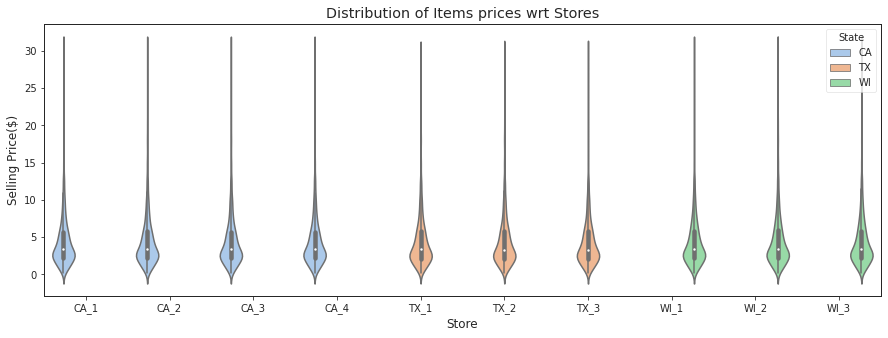

In [50]:
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna().copy()
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.violinplot(x="store_id", y="sell_price", data=group_price_store, hue='state_id', palette='pastel')
ax.set(xlabel='Store', ylabel='Selling Price($)', title='Distribution of Items prices wrt Stores')
ax.legend(title='State')
plt.show()

### 商家銷售分佈

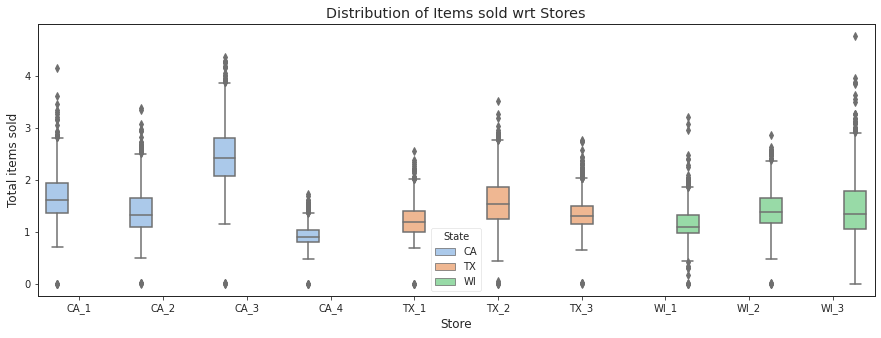

In [51]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sales'].mean().dropna().copy()
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.set_style('ticks')
sns.color_palette()
sns.boxplot(x="store_id", y="sales", data=group, hue='state_id', palette='pastel')
ax.set(xlabel='Store', ylabel='Total items sold', title='Distribution of Items sold wrt Stores')
ax.legend(title='State')
plt.show()

In [52]:
# 清除變數釋放記憶體
del group, group_price_store
gc.collect()

6870

### 各州SNAP 和 FOOD 銷售關聯

In [29]:
corr_data = df[['cat_id','state_id','sales','snap_CA','snap_TX','snap_WI']]
corr_data['snap_CA'] = corr_data['snap_CA'].astype('int16')
corr_data['snap_TX'] = corr_data['snap_TX'].astype('int16')
corr_data['snap_WI'] = corr_data['snap_WI'].astype('int16')
corr_data = corr_data.groupby(['cat_id','state_id']).corr()

In [9]:
mask = np.triu(np.ones_like(corr_data, dtype=bool))

In [10]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:ylabel='cat_id-state_id-None'>

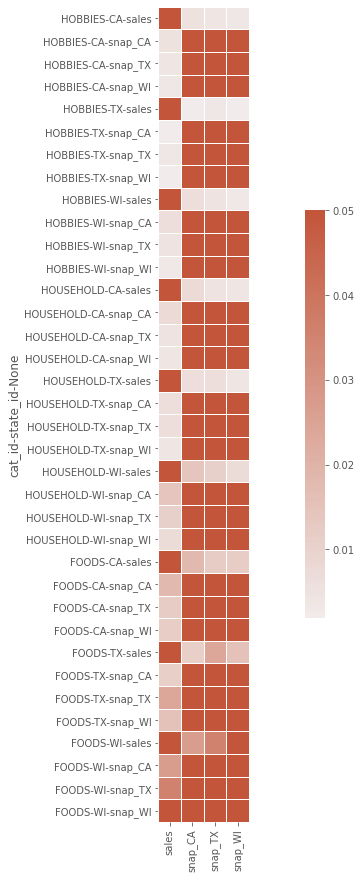

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.heatmap(corr_data, cmap=cmap, vmax=.05, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 不同類型商品的週月年規律

In [57]:
cat_sales = df[['cat_id', 'date', 'sales']].groupby(['cat_id', 'date']).mean().reset_index().copy()

In [58]:
example1 = df[df['cat_id'] == 'FOODS'].copy()
example2 = df[df['cat_id'] == 'HOUSEHOLD'].copy()
example3 = df[df['cat_id'] == 'HOBBIES'].copy()

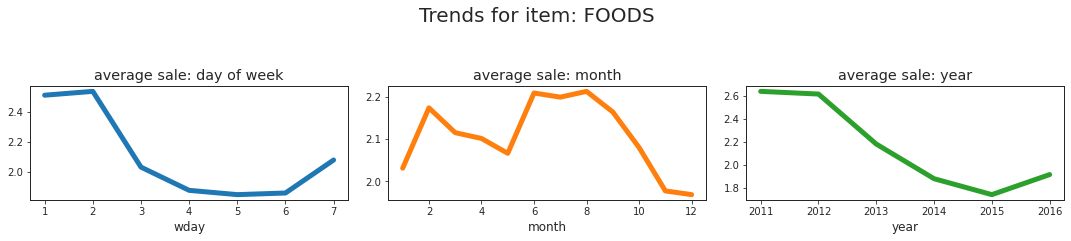

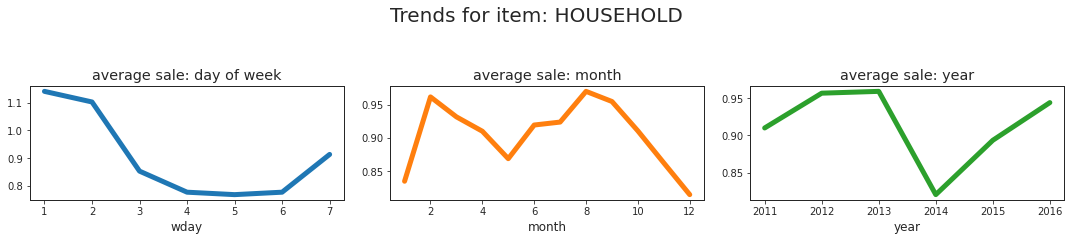

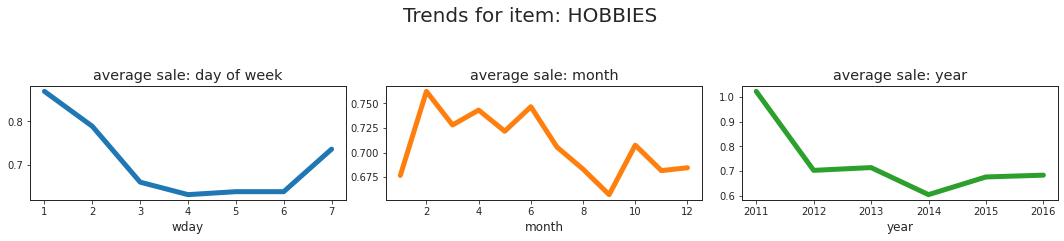

In [59]:
examples = ['FOODS','HOUSEHOLD', 'HOBBIES']
example_df = [example1, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()['sales'] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()['sales'] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[1],
              ax=ax2)
    example_df[i].groupby('year').mean()['sales'] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

### 不同類型商品銷售變化

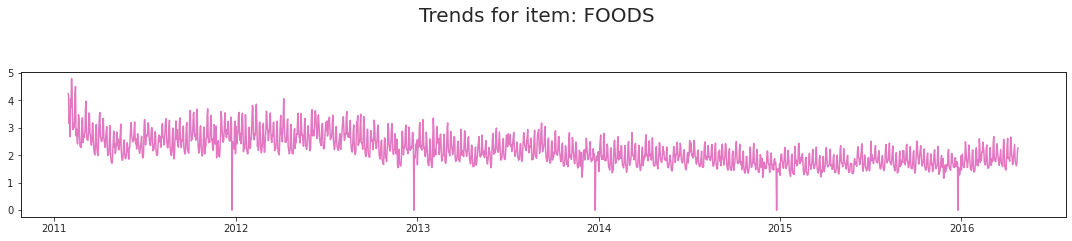

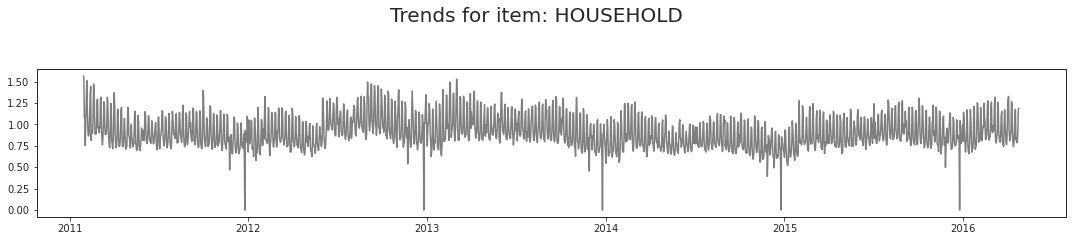

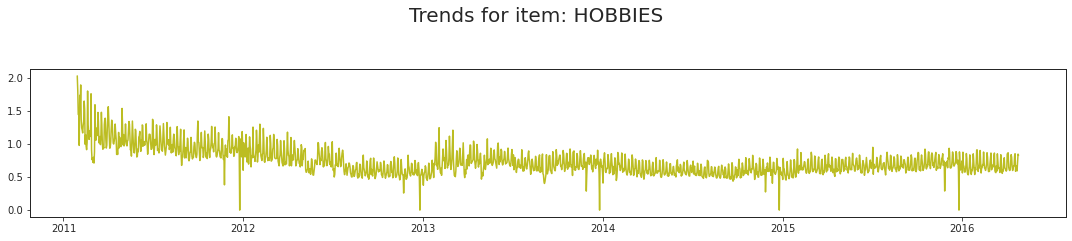

In [60]:
examples = ['FOODS','HOUSEHOLD', 'HOBBIES']
example_df = [example1, example2, example3]
for i in [0, 1, 2]:
    fig, ax = plt.subplots(figsize=(15, 3))
    plt.plot(cat_sales[cat_sales['cat_id'] == examples[i]]['date'], cat_sales[cat_sales['cat_id'] == examples[i]]['sales'], color=next(color_cycle))
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

In [61]:
# 清除變數釋放記憶體
del example1, example2, example3, examples, corr_data, cat_sales
gc.collect()

41860

# Model

### 資料讀取和整合

In [62]:
def create_df(is_train=True, nrows=None, first_day=1200):
    price = pd.read_csv(f'{DATA_FOLDER}/sell_prices.csv', dtype=PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price[col] = price[col].cat.codes.astype("int16")
            price[col] -= price[col].min()
    calendar = pd.read_csv(f'{DATA_FOLDER}/calendar.csv', dtype=CAL_DTYPES)
    calendar["date"] = pd.to_datetime(calendar["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            calendar[col] = calendar[col].cat.codes.astype("int16")
            calendar[col] -= calendar[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALES_DTYPES = {numcol:"float16" for numcol in numcols} 
    SALES_DTYPES.update({col: "category" for col in catcols if col != "id"})
#     SALES_DTYPES.update({col: "category" for col in catcols})
    sales_v = pd.read_csv(f'{DATA_FOLDER}/sales_train_validation.csv', nrows=nrows, usecols=catcols+numcols, dtype=SALES_DTYPES)
    
    for col in catcols:
        if col != "id":
            sales_v[col] = sales_v[col].cat.codes.astype("int16")
            sales_v[col] -= sales_v[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            sales_v[f"d_{day}"] = np.nan
    
    sales_v = pd.melt(sales_v,
                      id_vars=catcols,
                      value_vars=[col for col in sales_v.columns if col.startswith("d_")],
                      var_name="d",
                      value_name="sales")
    sales_v = sales_v.merge(calendar, on="d", copy=False)
    sales_v = sales_v.merge(price, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
    
    return sales_v

In [63]:
%%time
df = create_df(is_train=True, first_day=FIRST_DAY)
df.shape

CPU times: user 21.2 s, sys: 3.11 s, total: 24.3 s
Wall time: 24.3 s


(46027957, 22)

In [64]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0,0,0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0,0,0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0,0,0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1,1,0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1,0,1,0.459961


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       int16         
 19  snap_TX       int16         
 20  snap_WI       int16         
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(2), int16(17), object(2)
memory us

### 特徵建立

In [66]:
def create_fea(df):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag)
        df[f'{lag}_trend'] = df[["id","sales"]].groupby("id")["sales"].shift(7) - df[["id","sales"]].groupby("id")["sales"].shift(7).transform(lambda x : x.rolling(7).mean())

    wins = [7, 28]
    for win in wins:
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day"
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")

In [67]:
%%time
create_fea(df)
df.shape

CPU times: user 2min 1s, sys: 10.3 s, total: 2min 11s
Wall time: 2min 11s


(46027957, 33)

In [68]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,7_trend,lag_28,28_trend,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0,0,0,3.980469,0.0,-0.428571,1.0,-0.428571,1.000000,0.714355,0.928711,1.250000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,0,0,1.280273,0.0,-0.142857,2.0,-0.142857,0.856934,1.142578,1.036133,1.107422,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0,0,0,1.280273,1.0,0.714286,4.0,0.714286,0.714355,1.571289,1.036133,1.250000,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,0,0,1.000000,0.0,-0.285714,0.0,-0.285714,0.000000,2.285156,1.821289,1.786133,16,2,23
46027956,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0,0,0,1.000000,0.0,-0.285714,5.0,-0.285714,0.000000,2.427734,1.678711,1.963867,16,2,24


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 33 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       int16         
 19  snap_TX       int16         
 20  snap_WI       int16         
 21  sell_price    float16       
 22  lag_7         float16       
 23  7_trend       float64       
 

In [70]:
df.dropna(inplace=True)
df.shape

(44257191, 33)

In [71]:
df.to_pickle('lgbm_data.pkl')

In [72]:
df = pd.read_pickle('lgbm_data.pkl')

In [73]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,7_trend,lag_28,28_trend,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
617364,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_56,0.0,2011-03-25,11108,0,7,3,2011,0,0,0,0,0,0,0,0.419922,0.0,-2.000000,0.0,-2.000000,2.000000,4.000000,1.642578,4.535156,12,1,25
617371,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_56,0.0,2011-03-25,11108,0,7,3,2011,0,0,0,0,0,0,0,1.769531,0.0,-2.000000,0.0,-2.000000,2.000000,2.000000,2.142578,2.177734,12,1,25
617378,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_56,0.0,2011-03-25,11108,0,7,3,2011,0,0,0,0,0,0,0,3.169922,0.0,0.000000,0.0,0.000000,0.000000,0.142822,0.035706,0.214233,12,1,25
617385,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_56,1.0,2011-03-25,11108,0,7,3,2011,0,0,0,0,0,0,0,6.269531,1.0,0.571429,1.0,0.571429,0.428467,0.856934,0.535645,0.678711,12,1,25
617392,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_56,1.0,2011-03-25,11108,0,7,3,2011,0,0,0,0,0,0,0,0.720215,2.0,-3.428571,1.0,-3.428571,5.429688,8.000000,6.144531,4.320312,12,1,25


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44257191 entries, 617364 to 46027956
Data columns (total 33 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       int16         
 19  snap_TX       int16         
 20  snap_WI       int16         
 21  sell_price    float16       
 22  lag_7         float16       
 23  7_trend       float64    

### 選取特徵欄位

In [75]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

### 驗證資料切分

In [76]:
%%time
# time date vaild
valid_inds = df[df['date'] > (df['date'].max() - timedelta(days=30))].index.values
train_inds = np.setdiff1d(X_train.index.values, valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label=y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_train.loc[valid_inds], label=y_train.loc[valid_inds],
                         categorical_feature=cat_feats, free_raw_data=False)

CPU times: user 10.9 s, sys: 741 ms, total: 11.7 s
Wall time: 11.7 s


In [77]:
# 清除變數釋放記憶體
del df, X_train, y_train, valid_inds, train_inds
gc.collect()

90

In [ ]:
%%time
# final
train_data = lgb.Dataset(X_train.loc[X_train.index.values] , label=y_train.loc[X_train.index.values], 
                         categorical_feature=cat_feats, free_raw_data=False)

In [ ]:
del df, X_train, y_train, train_inds
gc.collect()

### 模型超參數

In [78]:
params = {
    'objective' : 'poisson',
    'metric' :'rmse',
    'force_row_wise' : True,
    'learning_rate' : 0.075,
#         "sub_feature" : 0.8,
    'bagging_fraction' : 0.75,
    'bagging_freq' : 1,
    'lambda_l2' : 0.2,
#         "nthread" : 4
    'verbosity': 1,
    'num_iterations' : 3000,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
    'max_depth': 100
}

### 模型訓練

In [79]:
%%time
# vaild
m_lgb = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Info] Total Bins 5104
[LightGBM] [Info] Number of data points in the train set: 43342595, number of used features: 27
[LightGBM] [Info] Start training from score 0.325567
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.49141	valid_1's rmse: 2.06648
[200]	training's rmse: 2.43513	valid_1's rmse: 2.05669
[300]	training's rmse: 2.39823	valid_1's rmse: 2.05341
[400]	training's rmse: 2.36869	valid_1's rmse: 2.05011
[500]	training's rmse: 2.34598	valid_1's rmse: 2.04448
[600]	training's rmse: 2.32716	valid_1's rmse: 2.04164
[700]	training's rmse: 2.31055	valid_1's rmse: 2.03949
[800]	training's rmse: 2.29205	valid_1's rmse: 2.03709
[900]	training's rmse: 2.2783	valid_1's rmse: 2.03527
[1000]	training's rmse: 2.26639	valid_1's rmse: 2.03402
[1100]	training's rmse: 2.25312	valid_1's rmse: 2.0328
[1200]	training's rmse: 2.24417	valid_1's rmse: 2.03185
[1300]	training's rmse: 2.23446	valid_1's rmse: 2.03102
[1400]	training's rmse: 2.22536	valid_

In [80]:
m_lgb.save_model("vaild_model.lgb")

In [ ]:
%%time
# final
m_lgb = lgb.train(params, train_data, valid_sets=[train_data], verbose_eval=100, early_stopping_rounds=100)

In [ ]:
m_lgb.save_model("final_model.lgb")

# Prediction

In [81]:
%%time

alphas = [1.035, 1.03, 1.025, 1.02]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    ouput = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = ouput[(ouput.date >= day - timedelta(days=max_lags)) & (ouput.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        ouput.loc[ouput.date == day, "sales"] = alpha * m_lgb.predict(tst) # magic multiplier by kyakovlev



    ouput_sub = ouput.loc[ouput.date >= fday, ["id", "sales"]].copy()
#     ouput_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = ouput_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    ouput_sub["F"] = [f"F{rank}" for rank in ouput_sub.groupby("id")["id"].cumcount()+1]
    ouput_sub = ouput_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    ouput_sub.fillna(0., inplace=True)
#     ouput_sub.sort_values("id", inplace=True)
    ouput_sub.reset_index(drop=True, inplace=True)
#     ouput_sub.to_csv("submission.csv",index=False)
    if icount == 0 :
        sub = ouput_sub
        sub[cols] *= weight
    else:
        sub[cols] += ouput_sub[cols]*weight
    print(icount, alpha, weight)


# sub2 = sub.copy()
# sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
# sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

0 2016-04-25 00:00:00
0 2016-04-26 00:00:00
0 2016-04-27 00:00:00
0 2016-04-28 00:00:00
0 2016-04-29 00:00:00
0 2016-04-30 00:00:00
0 2016-05-01 00:00:00
0 2016-05-02 00:00:00
0 2016-05-03 00:00:00
0 2016-05-04 00:00:00
0 2016-05-05 00:00:00
0 2016-05-06 00:00:00
0 2016-05-07 00:00:00
0 2016-05-08 00:00:00
0 2016-05-09 00:00:00
0 2016-05-10 00:00:00
0 2016-05-11 00:00:00
0 2016-05-12 00:00:00
0 2016-05-13 00:00:00
0 2016-05-14 00:00:00
0 2016-05-15 00:00:00
0 2016-05-16 00:00:00
0 2016-05-17 00:00:00
0 2016-05-18 00:00:00
0 2016-05-19 00:00:00
0 2016-05-20 00:00:00
0 2016-05-21 00:00:00
0 2016-05-22 00:00:00
0 1.035 0.25
1 2016-04-25 00:00:00
1 2016-04-26 00:00:00
1 2016-04-27 00:00:00
1 2016-04-28 00:00:00
1 2016-04-29 00:00:00
1 2016-04-30 00:00:00
1 2016-05-01 00:00:00
1 2016-05-02 00:00:00
1 2016-05-03 00:00:00
1 2016-05-04 00:00:00
1 2016-05-05 00:00:00
1 2016-05-06 00:00:00
1 2016-05-07 00:00:00
1 2016-05-08 00:00:00
1 2016-05-09 00:00:00
1 2016-05-10 00:00:00
1 2016-05-11 00:00: